In [1]:
include("speciale_tools.jl")
import JLD
import PyPlot

In [2]:
data_folder = "/home/data/simon/processed/test_areas/ribe_new/flood"
figure_folder = "/home/data/simon/result/HSBA_ribe"

VV = [JLD.load(joinpath(data_folder,"VV_co.jld"),"data"),
    JLD.load(joinpath(data_folder,"VV_pre_median.jld"),"data")]


VH = [JLD.load(joinpath(data_folder,"VH_co.jld"),"data"), 
    JLD.load(joinpath(data_folder,"VH_pre_median.jld"),"data")];


In [3]:
threshold_indx = 3

3

## VV

In [57]:
co = VV[1][end:-1:1,:]
pre = VV[2][end:-1:1,:];

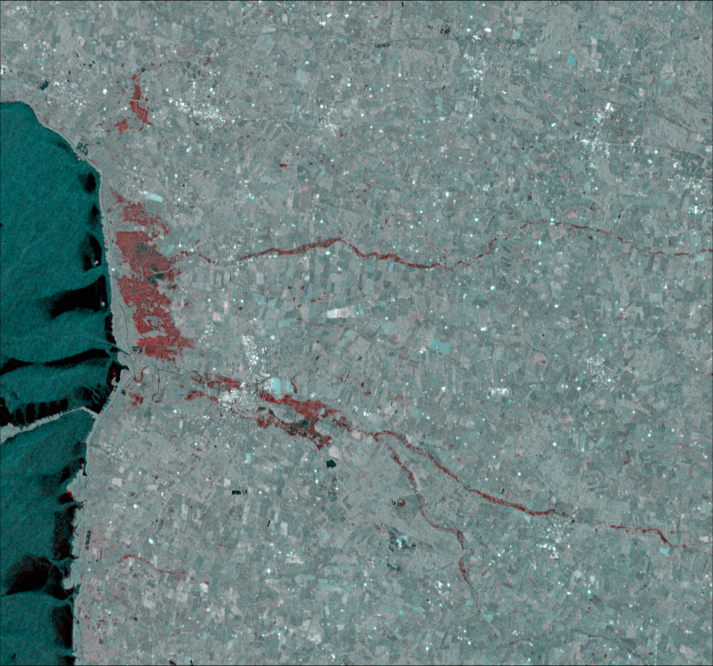

In [58]:
imgVV = pretty_img([co,pre],min_vv,max_vv)

In [59]:
flood_band = 10 .*log10.(co);
ref_band = 10 .*log10.(pre);
change_band = flood_band .- ref_band;

In [60]:
# Find the tiles to fit bimodal
bm_mask_flood = find_bimodal_tiles(flood_band);
bm_mask_change = find_bimodal_tiles(change_band);
bm_mask = bm_mask_change.&bm_mask_flood;


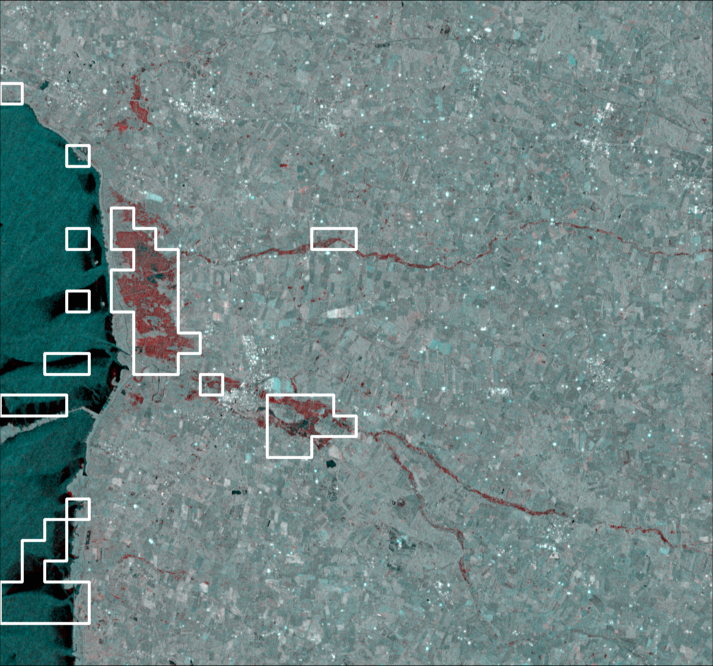

In [61]:
subset_edges = get_edges(bm_mask);
img_save = add_mask(imgVV,subset_edges,(1,1,1))

file_path = joinpath(figure_folder,"VV_tile_select_median")
FileIO.save(file_path*".png",img_save)
img_save

In [62]:
# fit bimodel
data = reshape(flood_band,:)[reshape(bm_mask,:)]
p_fit,y,w,edges, w_sum = fit_bimodal_gauss(data,round(Int64,length(data)/50))

# Find seed pixels
y_seed =find_y_seed(p_fit,y)
seed_mask = flood_band .<y_seed;


In [43]:
t_0 = [y_seed+1, -1]
thresholds3, n_iter = grad_decent(
            (t1,t2) -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [t1,t2])
            ,t_0,debug=true)
f3 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds3);


Iterration : 1
x_i: [-12.65, -1.0], f_i: 0.00013639885465942519
dfdx: [0.0, 0.0]

Iterration : 2
x_i: [-12.65, -1.0], f_i: 0.00013639885465942519
dfdx: [0.0, -3.130927349236848e-5]
Step x, step_idx:5,  no_step: -2

Iterration : 3
x_i: [-12.65, 30.309273492368483], f_i: 9.564768225779815e-5
dfdx: [-4.5219632212548245e-5, 0.0]
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Step x, step_idx:3,  no_step: -2

Iterration : 4
x_i: [-12.197803677874518, 30.309273492368483], f_i: 8.259402112681135e-5
dfdx: [-1.5094530299487548e-5, 0.0]
Max Iter reached:  region_growing()
Step x, step_idx:3,  no_step: -2

Iterration : 5
x_i: [-12.046858374879642, 30.309273492368483], f_i: 8.086440703703056e-5
dfdx: [-8.442495669808905e-6, 0.0]
Max Iter reached:  region_growing()
Step x, step_idx:3,  no_step: -2
Max Iter reached:  region_growing()

Iterration : 6
x_i: [-11.962433418181552, 30.309273492368483], f_i: 8.037210224943624e-5
dfdx: [1.7991483346535994e-5, 0.0]
Step x, step_idx:

In [44]:
thresholds3, f3

([-11.948387497746245, 30.3152732941629], 8.016653120559034e-5)

In [45]:
t_0 = [y_seed+1, -1]
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, t), 
    t_0; autodiff = :forward,store_trace = true,trace_simplex=true)
thresholds1 = res.minimizer
f1 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds1)
thresholds1, f1

([-11.910319226980002, 10.484676741063605], 8.0059832517855e-5)

In [46]:
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [t,10]),
    y_seed, p_fit[4])

y_RG = res.minimizer
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [y_RG,t]),
    -5, 2)
thresholds2 = [y_RG, res.minimizer]
f2 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds2)
thresholds2, f2

([-11.910370764291905, 1.9907355870396475], 0.00010040156486329262)

In [47]:
rg_thresholds = [thresholds1,thresholds2,thresholds3][threshold_indx];

In [52]:
folder_names_path = joinpath(figure_folder,"thresholds_parameters_VV.txt")   
open(folder_names_path, "w") do io
    write(io, "opt_mul, $(thresholds1[1]), $(thresholds1[2]), $f1 \n")
    write(io, "opt_uni, $(thresholds2[1]), $(thresholds2[2]), $f2 \n")
    write(io, "opt_own, $(thresholds3[1]), $(thresholds3[2]), $f3 \n")
end;

In [18]:
test_sigma = collect(LinRange(y_seed,-8,20))
test_dsigma = collect(LinRange(-2,3,20))
@time loss = [sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [r1,r2])
    for r1=test_sigma, r2=test_dsigma];

Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_gr

In [19]:
minimum(loss),maximum(loss)

(5.5616649319283434e-6, 0.0012426591534814746)

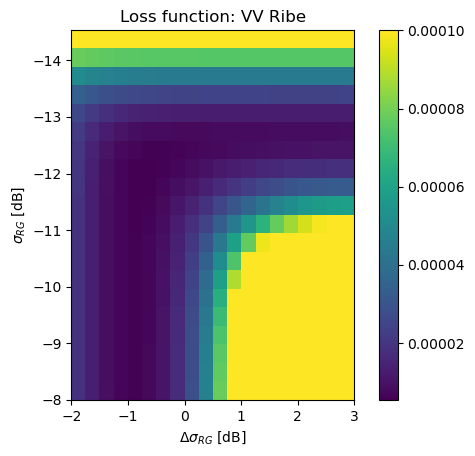

In [24]:
file_path = joinpath(figure_folder,"VV_loss_function.png")
PyPlot.figure(0.001)
PyPlot.imshow(loss,vmin=0.0000055,vmax=0.0001
    ,extent=[test_dsigma[1],test_dsigma[end],test_sigma[end],test_sigma[1]])
PyPlot.xlabel("\$\\Delta \\sigma_{RG} \$ [dB]")
PyPlot.ylabel("\$\\sigma_{RG} \$ [dB]")
PyPlot.colorbar()
PyPlot.title("Loss function: VV Ribe")
PyPlot.savefig(file_path)

In [63]:
#y_seed =-15
rg_thresholds = [-12.8,-1]
seed_mask = flood_band .< y_seed;
y_seed

-13.65

In [64]:
rg_mask = (flood_band .<rg_thresholds[1]) .& (change_band.<rg_thresholds[2]) .| seed_mask 
flood_mask, steps = region_growing(seed_mask,rg_mask);

In [65]:
# select the water pixelss in the selected tiles
data = reshape(flood_band,:)[reshape(rg_mask.&bm_mask,:)];
    
# Compare histogram with the emepircal in p_water
h = StatsBase.fit(StatsBase.Histogram, data,edges)
w_sel = h.weights./w_sum;

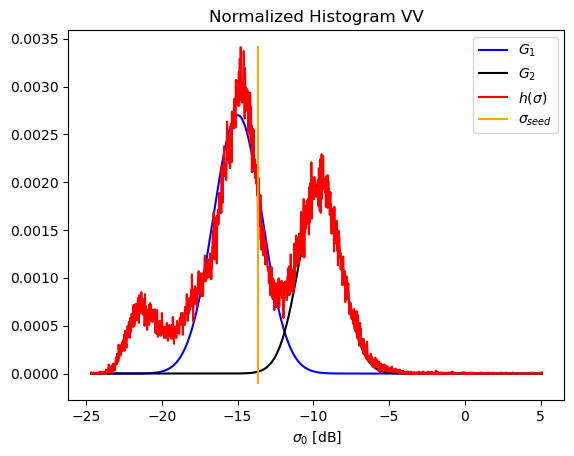

In [66]:
file_path = joinpath(figure_folder,"VV_histogram_tiles_tuned.png")
PyPlot.figure()

PyPlot.plot(y,gauss_model(y,p_fit[[1,3,5]]),color="b")
PyPlot.plot(y,gauss_model(y,p_fit[[2,4,6]]),color="k")
PyPlot.plot(y,w,color="r")
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w)-0.0001,maximum(w),8),color="orange")

PyPlot.xlabel("\$\\sigma_0 \$ [dB]")
PyPlot.title("Normalized Histogram VV")
PyPlot.legend(["\$ G_1 \$","\$ G_2 \$","\$ h(\\sigma) \$","\$\\sigma_{seed} \$"])

PyPlot.savefig(file_path)

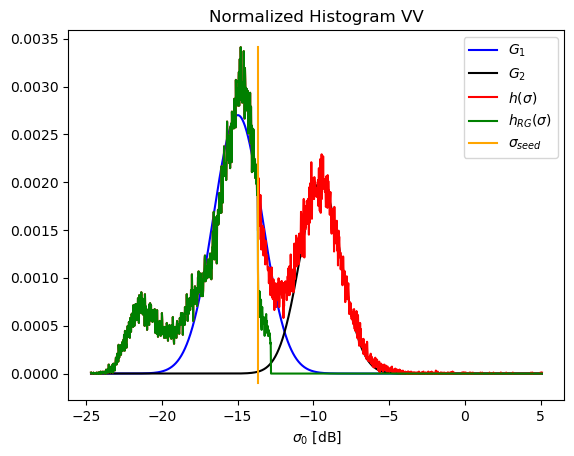

In [67]:
file_path = joinpath(figure_folder,"VV_histogram_flood_tuned.png")
PyPlot.figure()

PyPlot.plot(y,gauss_model(y,p_fit[[1,3,5]]),color="b")
PyPlot.plot(y,gauss_model(y,p_fit[[2,4,6]]),color="k")
PyPlot.plot(y,w,color="r")
PyPlot.plot(y,w_sel,color="g")
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w)-0.0001,maximum(w),8),color="orange")

PyPlot.xlabel("\$\\sigma_0 \$ [dB]")
PyPlot.title("Normalized Histogram VV")
PyPlot.legend(["\$ G_1 \$","\$ G_2 \$","\$ h(\\sigma) \$","\$ h_{RG}(\\sigma) \$" ,"\$\\sigma_{seed} \$"])

PyPlot.savefig(file_path)

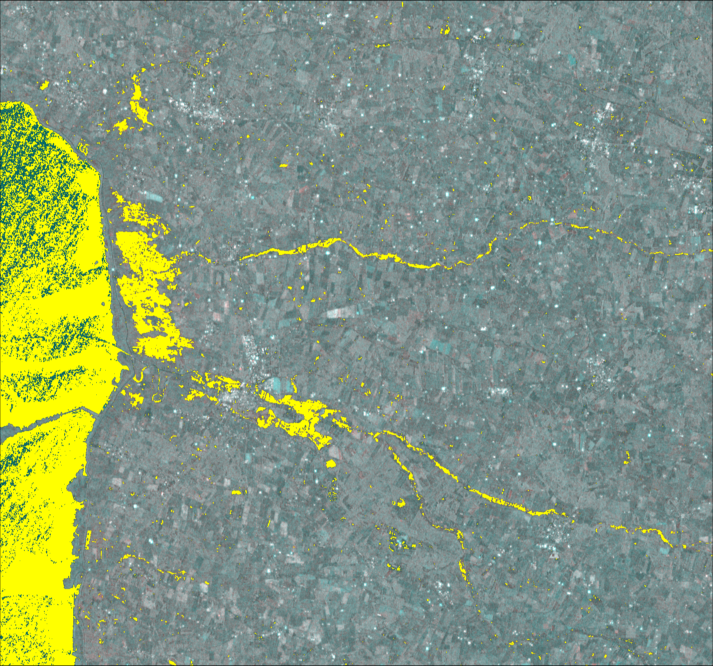

In [68]:
img_save = add_mask(imgVV,flood_mask,(1,1,0))
file_path = joinpath(figure_folder,"VV_flood_noref_tuned")
FileIO.save(file_path*".png",img_save)
img_save

In [69]:
seed_mask_ref = ref_band .<y_seed
rg_mask_ref = (ref_band .<rg_thresholds[1]) .| seed_mask_ref
ref_mask, steps = region_growing(seed_mask_ref,rg_mask_ref);
    
# Remove flase positives and permant water.
final_mask = flood_mask .& (ref_mask .!=true);

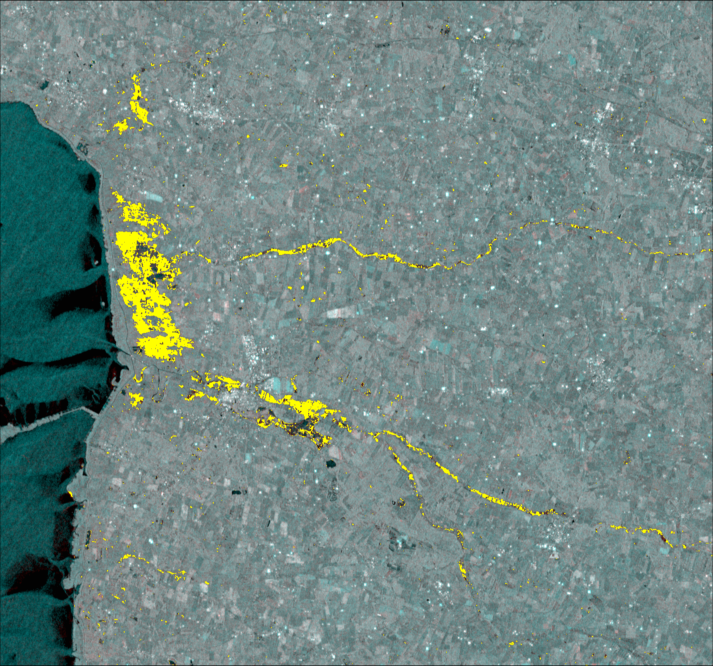

In [70]:
img_save = add_mask(imgVV,final_mask,(1,1,0))

file_path = joinpath(figure_folder,"VV_flood_tuned")
FileIO.save(file_path*".png",img_save)
img_save

In [71]:
file_path = joinpath(data_folder,"VVhand_tuned_mask")
JLD.save(file_path*".jld", "data", final_mask)

## VH

In [30]:
co = VH[1][end:-1:1,:]
pre = VH[2][end:-1:1,:];

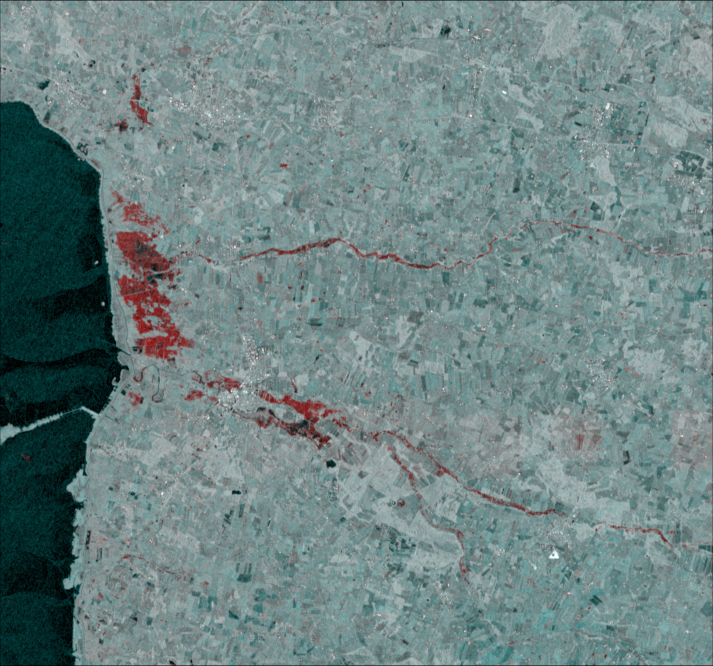

In [31]:
imgVH = pretty_img([co,pre],min_vh,max_vh)

In [32]:
flood_band = 10 .*log10.(co);
ref_band = 10 .*log10.(pre);
change_band = flood_band .- ref_band;

In [33]:
# Find the tiles to fit bimodal
bm_mask_flood = find_bimodal_tiles(flood_band);
bm_mask_change = find_bimodal_tiles(change_band);
bm_mask = bm_mask_change.&bm_mask_flood;


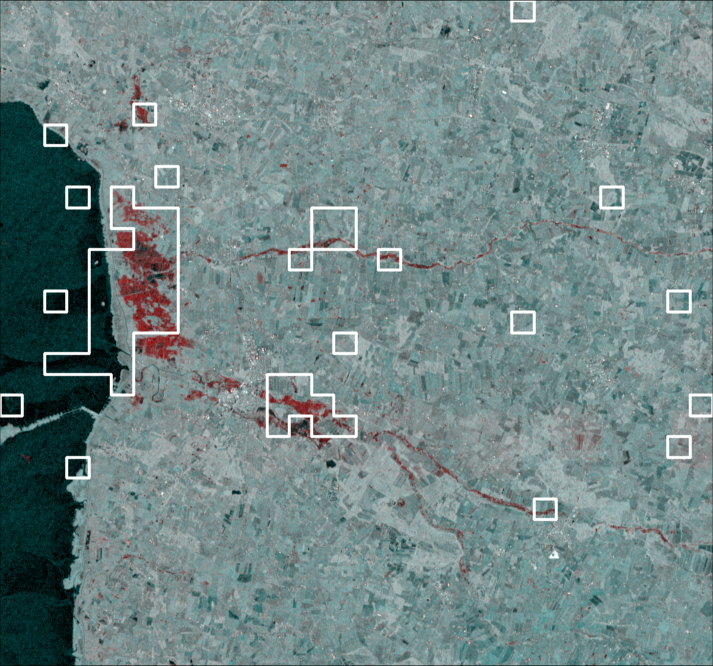

In [34]:
subset_edges = get_edges(bm_mask);
img_save = add_mask(imgVH,subset_edges,(1,1,1))

file_path = joinpath(figure_folder,"VH_tile_select_median")
FileIO.save(file_path*".png",img_save)
img_save

In [35]:
# fit bimodel
data = reshape(flood_band,:)[reshape(bm_mask,:)]
p_fit,y,w,edges, w_sum = fit_bimodal_gauss(data,round(Int64,length(data)/50))

# Find seed pixels
y_seed =find_y_seed(p_fit,y)
seed_mask = flood_band .<y_seed;


In [68]:
t_0 = [y_seed+1, -1]
thresholds3, n_iter = grad_decent(
            (t1,t2) -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [t1,t2])
            ,t_0,debug=true)
f3 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds3);


Iterration : 1
x_i: [-21.41, -1.0], f_i: 8.395851748250443e-6
dfdx: [0.0, 0.0]

Iterration : 2
x_i: [-21.41, -1.0], f_i: 8.395851748250443e-6
dfdx: [-3.910599097328415e-6, -2.4092488637811754e-6]
Step x, step_idx:4,  no_step: -2

Iterration : 3
x_i: [-21.018940090267158, -0.7590751136218825], f_i: 7.617755666605865e-6
dfdx: [2.7866417346227064e-7, -2.9498797692543526e-7]
Step x, step_idx:4,  no_step: -2

Iterration : 4
x_i: [-21.046806507613386, -0.729576315929339], f_i: 7.592662880952186e-6
dfdx: [-4.877235683129374e-7, -1.4020924920822517e-7]
No change, Decrease delta, no_step: -1

Iterration : 5
x_i: [-21.046806507613386, -0.729576315929339], f_i: 7.592662880952186e-6
dfdx: [-4.877235683129374e-7, -1.4020924920822517e-7]
No change, Decrease delta, no_step: 0

Iterration : 6
x_i: [-21.046806507613386, -0.729576315929339], f_i: 7.592662880952186e-6
dfdx: [-4.877235683129374e-7, -1.4020924920822517e-7]
No change, Decrease delta, no_step: 1

Iterration : 7
x_i: [-21.046806507613386, -0

In [69]:
thresholds3, f3

([-21.046806507613386, -0.729576315929339], 7.592662880952186e-6)

In [70]:
t_0 = [y_seed+1, -1]
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, t), 
    t_0; autodiff = :forward,store_trace = true,trace_simplex=true)
thresholds1 = res.minimizer
f1 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds1)
thresholds1, f1

([-20.9928125, -1.06865234375], 7.5905128409478565e-6)

In [71]:
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [t,10]),
    y_seed, p_fit[4])

y_RG = res.minimizer
res = Optim.optimize(
    t -> sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [y_RG,t]),
    -5, 2)
thresholds2 = [y_RG, res.minimizer]
f2 = sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y,thresholds2)
thresholds2, f2

([-21.228905829465873, 0.3475241677502607], 7.706502497087276e-6)

In [72]:
rg_thresholds = [thresholds1,thresholds2,thresholds3][threshold_indx];

In [80]:
folder_names_path = joinpath(figure_folder,"thresholds_parameters_VH.txt")   
open(folder_names_path, "w") do io
    write(io, "opt_mul, $(thresholds1[1]), $(thresholds1[2]), $f1 \n")
    write(io, "opt_uni, $(thresholds2[1]), $(thresholds2[2]), $f2 \n")
    write(io, "opt_own, $(thresholds3[1]), $(thresholds3[2]), $f3 \n")
end;

In [32]:
test_sigma = collect(LinRange(y_seed,-16,20))
test_dsigma = collect(LinRange(-2,3,20))
@time loss = [sse_water_fit(flood_band,change_band,seed_mask,bm_mask, p_fit[[1,3,5]],w_sum,edges,y, [r1,r2])
    for r1=test_sigma, r2=test_dsigma];

Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
Max Iter reached:  region_growing()
402.734916 seconds (15.31 M allocations: 35.998 GiB, 0.09% gc time)


In [33]:
minimum(loss),maximum(loss)

(3.5564882228405167e-6, 0.00035116561561543056)

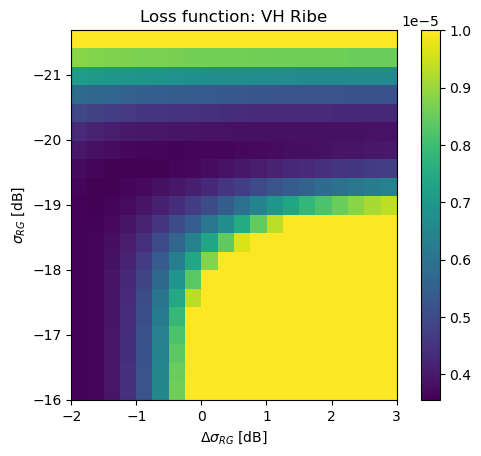

In [39]:
file_path = joinpath(figure_folder,"VH_loss_function.png")
PyPlot.figure(0.001)
PyPlot.imshow(loss,vmin=0.000003556,vmax=0.00001
    ,extent=[test_dsigma[1],test_dsigma[end],test_sigma[end],test_sigma[1]])
PyPlot.xlabel("\$\\Delta \\sigma_{RG} \$ [dB]")
PyPlot.ylabel("\$\\sigma_{RG} \$ [dB]")
PyPlot.colorbar()
PyPlot.title("Loss function: VH Ribe")
PyPlot.savefig(file_path)

In [45]:
#y_seed =-15
rg_thresholds = [-20,-1.5]
seed_mask = flood_band .< y_seed;
y_seed

-22.41

In [46]:
rg_mask = (flood_band .<rg_thresholds[1]) .& (change_band.<rg_thresholds[2]) .| seed_mask 
flood_mask, steps = region_growing(seed_mask,rg_mask);

In [47]:
# select the water pixelss in the selected tiles
data = reshape(flood_band,:)[reshape(rg_mask.&bm_mask,:)];
    
# Compare histogram with the emepircal in p_water
h = StatsBase.fit(StatsBase.Histogram, data,edges)
w_sel = h.weights./w_sum;

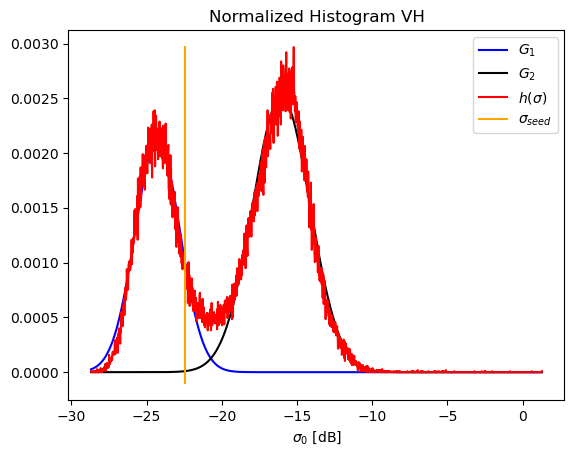

In [48]:
file_path = joinpath(figure_folder,"VH_histogram_tiles_tuned.png")
PyPlot.figure()

PyPlot.plot(y,gauss_model(y,p_fit[[1,3,5]]),color="b")
PyPlot.plot(y,gauss_model(y,p_fit[[2,4,6]]),color="k")
PyPlot.plot(y,w,color="r")
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w)-0.0001,maximum(w),8),color="orange")

PyPlot.xlabel("\$\\sigma_0 \$ [dB]")
PyPlot.title("Normalized Histogram VH")
PyPlot.legend(["\$ G_1 \$","\$ G_2 \$","\$ h(\\sigma) \$","\$\\sigma_{seed} \$"])

PyPlot.savefig(file_path)

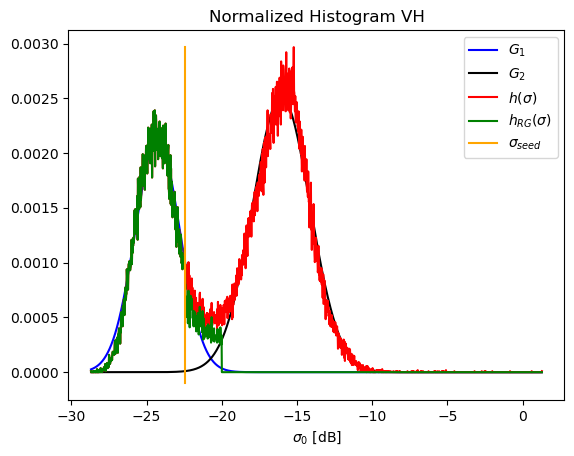

In [49]:
file_path = joinpath(figure_folder,"VH_histogram_flood_tuned.png")
PyPlot.figure()

PyPlot.plot(y,gauss_model(y,p_fit[[1,3,5]]),color="b")
PyPlot.plot(y,gauss_model(y,p_fit[[2,4,6]]),color="k")
PyPlot.plot(y,w,color="r")
PyPlot.plot(y,w_sel,color="g")
PyPlot.plot(ones(8)*(y_seed),LinRange(minimum(w)-0.0001,maximum(w),8),color="orange")

PyPlot.xlabel("\$\\sigma_0 \$ [dB]")
PyPlot.title("Normalized Histogram VH")
PyPlot.legend(["\$ G_1 \$","\$ G_2 \$","\$ h(\\sigma) \$","\$ h_{RG}(\\sigma) \$" ,"\$\\sigma_{seed} \$"])

PyPlot.savefig(file_path)

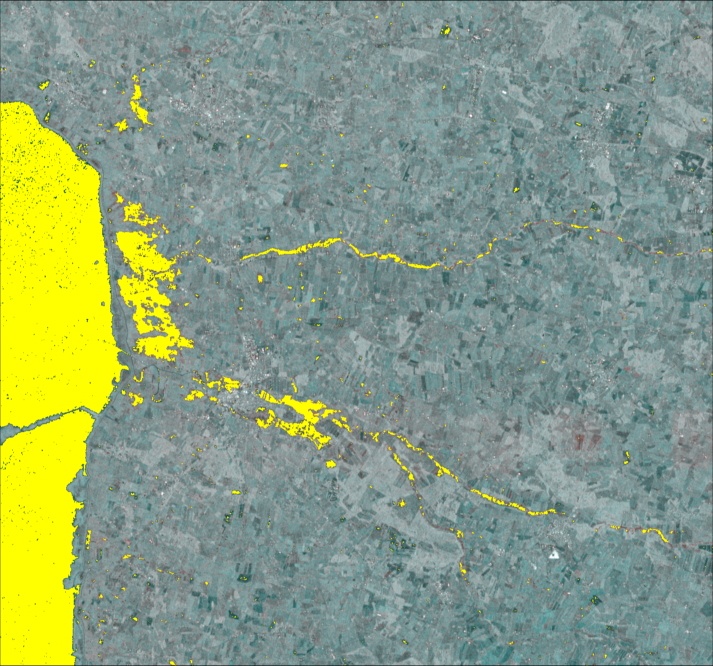

In [50]:
img_save = add_mask(imgVH,flood_mask,(1,1,0))
file_path = joinpath(figure_folder,"VH_flood_noref_tuned")
FileIO.save(file_path*".png",img_save)
img_save

In [51]:
seed_mask_ref = ref_band .<y_seed
rg_mask_ref = (ref_band .<rg_thresholds[1]) .| seed_mask_ref
ref_mask, steps = region_growing(seed_mask_ref,rg_mask_ref);
    
# Remove flase positives and permant water.
final_mask = flood_mask .& (ref_mask .!=true);

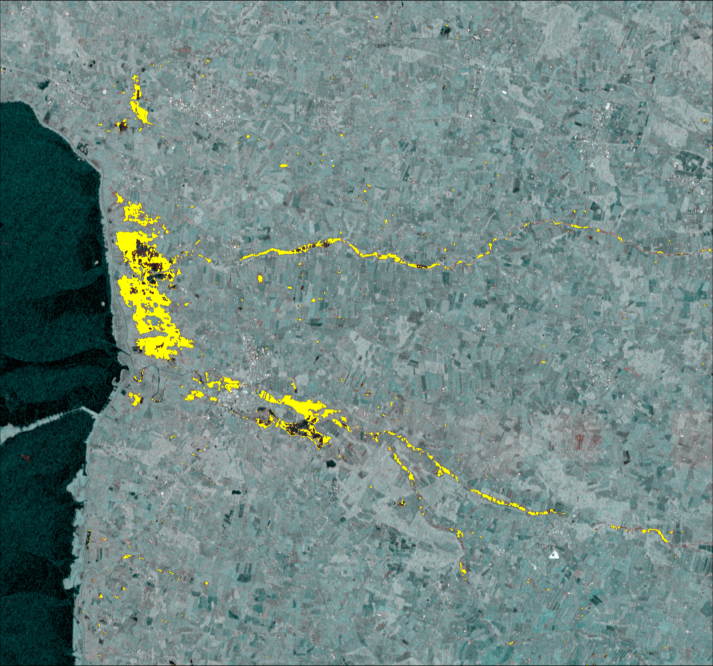

In [55]:
img_save = add_mask(imgVH,final_mask,(1,1,0))

file_path = joinpath(figure_folder,"VH_flood_tuned")
FileIO.save(file_path*".png",img_save)
img_save

In [56]:
file_path = joinpath(data_folder,"VHhand_tuned_mask")
JLD.save(file_path*".jld", "data", final_mask)